In [ ]:
!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [ ]:
!pip install lazypredict

In [2]:
import plotly.express as px
import pandas as pd
import numpy as np
coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/distan_lat42.896lon-8.415p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [4]:
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/LESTY2018Y2022.csv",
                          usecols =["time","wxcodes_o"],
                          parse_dates=["time"]).dropna().set_index("time")

pd.options.display.max_rows = 999
print("Weather frequencies\n")
station["wxcodes_o"].value_counts(normalize=True).map(lambda n: '{:.2%}'.format(n))

Weather frequencies



M                  73.21%
-RA                 6.38%
BCFG                5.29%
FG                  1.93%
BR                  1.70%
RA                  1.63%
-SHRA               1.60%
VCFG                1.29%
-DZ                 1.14%
SHRA                0.68%
-RA BR              0.54%
-RADZ               0.49%
-DZ BCFG            0.48%
-DZ BR              0.45%
-RA BCFG            0.39%
VCSH                0.24%
RA BR               0.17%
+RA                 0.16%
-RADZ BR            0.15%
-RADZ BCFG          0.15%
BCFG -DZ            0.15%
DZ BR               0.13%
-DZ FG              0.11%
PRFG                0.10%
DZ                  0.10%
+SHRA               0.09%
DZ BCFG             0.09%
FZFG                0.07%
MIFG                0.07%
VCTS                0.07%
TS                  0.06%
RA BCFG             0.06%
-TSRA               0.04%
BR -DZ              0.04%
-DZRA               0.04%
BCFG -RA            0.04%
FG -DZ              0.03%
BR -RA              0.03%
TSRA        

In [5]:
#label br/fg if weather code contains FG or BR

station["brfg_l"] = "No BR/FG"
mask = station['wxcodes_o'].str.contains("BR")
station.loc[mask,["brfg_l"]] = "BR/FG"
mask = station['wxcodes_o'].str.contains("FG")
station.loc[mask,["brfg_l"]] = "BR/FG"
pd.options.display.max_rows = 999

print(station.sample(50))
print("*****************************")
station["brfg_l"].value_counts(normalize=True).transform(lambda x: '{:,.0%}'.format(x))

                    wxcodes_o    brfg_l
time                                   
2022-07-09 03:00:00         M  No BR/FG
2020-09-28 20:00:00         M  No BR/FG
2021-09-30 13:30:00         M  No BR/FG
2022-12-20 05:00:00       -RA  No BR/FG
2022-12-26 18:00:00         M  No BR/FG
2018-10-03 06:00:00         M  No BR/FG
2022-11-08 19:00:00         M  No BR/FG
2019-01-16 09:47:00   BR BCFG     BR/FG
2019-09-21 04:00:00         M  No BR/FG
2019-08-04 08:00:00         M  No BR/FG
2019-04-17 12:00:00         M  No BR/FG
2019-10-26 22:30:00         M  No BR/FG
2022-06-27 12:00:00         M  No BR/FG
2021-08-03 07:00:00      BCFG     BR/FG
2021-06-07 04:30:00         M  No BR/FG
2018-08-13 07:30:00        BR     BR/FG
2018-08-11 16:30:00         M  No BR/FG
2018-01-26 01:30:00         M  No BR/FG
2021-10-25 04:06:00        BR     BR/FG
2019-12-22 07:00:00       -RA  No BR/FG
2020-05-10 14:30:00         M  No BR/FG
2022-06-21 19:00:00        RA  No BR/FG
2018-06-30 14:30:00   SHRA TS  No BR/FG


No BR/FG    86%
BR/FG       14%
Name: brfg_l, dtype: object

**Load met model**

In [6]:
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2022.csv",parse_dates=["time"])
model1k = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

model1k

,dir0,snow_prec0,snowlevel0,mod0,wind_gust0,mslp0,temp0,rh0,visibility0,lhflx0,...,cape3,cin3,cfh3,cfl3,cfm3,cft3,HGT5003,HGT8503,T5003,T8503
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,203.429932,0.0,854.856445,4.810002,11.869287,102894.039062,280.189117,0.941392,24051.365234,-0.485709,...,0.000000,-0.000477,0.2,0.000000,0.000000,0.200000,5556.550781,1547.730957,249.389938,273.540863
2018-01-01 02:00:00,215.205261,0.0,896.619629,5.700827,12.852463,102861.617188,280.347931,0.988324,24039.359375,-4.395393,...,26.730000,-14.053461,0.2,0.120898,0.000000,0.200000,5565.350098,1546.713013,249.959381,273.725189
2018-01-01 03:00:00,224.525986,0.0,921.870178,7.366050,16.131567,102839.406250,281.068298,0.952302,24040.320312,-3.568437,...,30.040001,-11.045238,0.2,0.164062,0.000000,0.200000,5573.533203,1546.541992,250.329880,273.646881
2018-01-01 04:00:00,227.065903,0.0,940.589844,8.982346,17.282509,102842.039062,281.655243,0.923813,24042.085938,-1.595969,...,32.810001,-8.397157,0.1,0.437500,0.000000,0.437500,5580.626953,1548.500977,250.527191,273.661194
2018-01-01 05:00:00,231.667892,0.0,983.509766,10.026832,18.146084,102827.226562,282.484192,0.924759,24040.648438,0.638913,...,58.730000,-4.643547,0.1,0.375000,0.000000,0.375000,5585.084961,1548.863037,250.680435,273.858765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,192.131683,0.0,1647.268433,8.436563,14.080066,101383.421875,283.931366,0.971286,4439.524902,6.396758,...,16.520000,-12.663813,0.1,0.484375,0.328125,0.484375,5534.582031,1469.921997,255.214996,277.491058
2022-12-31 20:00:00,210.602203,0.0,1613.758667,5.970586,9.454391,101500.343750,284.023376,0.981433,8239.185547,3.192404,...,50.250000,-0.009562,0.2,0.480000,0.203125,0.480000,5538.076172,1474.437012,255.085251,276.761200
2022-12-31 21:00:00,204.022858,0.0,1617.162964,7.379550,13.501737,101569.578125,284.019989,0.973716,9444.787109,3.996242,...,53.689999,-0.000937,0.1,0.439746,0.203125,0.439746,5541.597168,1477.406982,255.229691,276.760620


In [7]:
#concat station file versus meteorological model file same time
df_all1k = pd.concat([station,model1k],axis=1).drop(columns=["wxcodes_o",]).dropna()
df_all1k

,brfg_l,dir0,snow_prec0,snowlevel0,mod0,wind_gust0,mslp0,temp0,rh0,visibility0,...,cape3,cin3,cfh3,cfl3,cfm3,cft3,HGT5003,HGT8503,T5003,T8503
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,No BR/FG,203.429932,0.0,854.856445,4.810002,11.869287,102894.039062,280.189117,0.941392,24051.365234,...,0.000000,-0.000477,0.2,0.000000,0.000000,0.200000,5556.550781,1547.730957,249.389938,273.540863
2018-01-01 02:00:00,No BR/FG,215.205261,0.0,896.619629,5.700827,12.852463,102861.617188,280.347931,0.988324,24039.359375,...,26.730000,-14.053461,0.2,0.120898,0.000000,0.200000,5565.350098,1546.713013,249.959381,273.725189
2018-01-01 03:00:00,BR/FG,224.525986,0.0,921.870178,7.366050,16.131567,102839.406250,281.068298,0.952302,24040.320312,...,30.040001,-11.045238,0.2,0.164062,0.000000,0.200000,5573.533203,1546.541992,250.329880,273.646881
2018-01-01 04:00:00,BR/FG,227.065903,0.0,940.589844,8.982346,17.282509,102842.039062,281.655243,0.923813,24042.085938,...,32.810001,-8.397157,0.1,0.437500,0.000000,0.437500,5580.626953,1548.500977,250.527191,273.661194
2018-01-01 05:00:00,No BR/FG,231.667892,0.0,983.509766,10.026832,18.146084,102827.226562,282.484192,0.924759,24040.648438,...,58.730000,-4.643547,0.1,0.375000,0.000000,0.375000,5585.084961,1548.863037,250.680435,273.858765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 19:00:00,No BR/FG,206.390732,0.0,2074.267090,13.522949,21.508442,101436.859375,286.881622,0.966220,6238.053223,...,8.360000,-3.452000,0.2,0.828125,0.656250,0.828125,5584.145020,1486.342041,257.560760,280.863312
2022-12-30 20:00:00,No BR/FG,203.653366,0.0,2074.872559,13.675614,21.609047,101487.148438,286.931366,0.958984,9636.106445,...,9.360000,-1.589551,0.1,0.781250,0.671875,0.781250,5587.791992,1489.608032,257.591125,280.822876
2022-12-30 21:00:00,No BR/FG,203.530945,0.0,2036.689697,12.965158,20.540071,101528.273438,286.895935,0.955559,8634.944336,...,11.790000,-0.158887,0.1,0.890625,0.796875,0.890625,5590.491211,1491.394043,257.582001,280.443878


No BR/FG    88
BR/FG       12
Name: brfg_l, dtype: int64

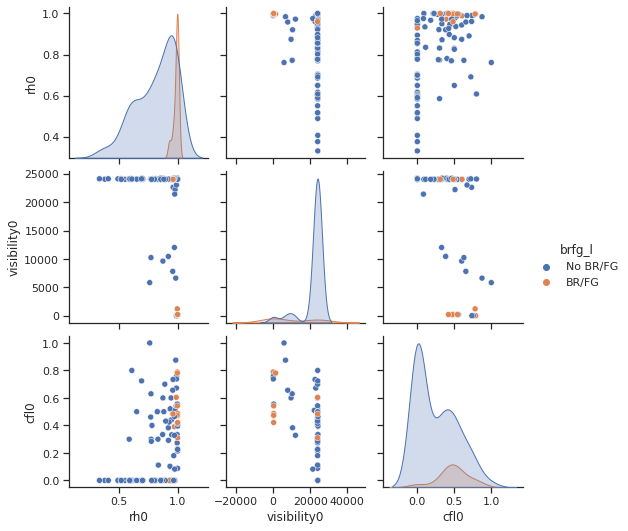

In [8]:
import seaborn as sns
sns.set_theme(style="ticks")
df = df_all1k[["brfg_l","rh0","visibility0","cfl0"]].sample(100)
sns.pairplot(df, hue="brfg_l");
df["brfg_l"].value_counts()

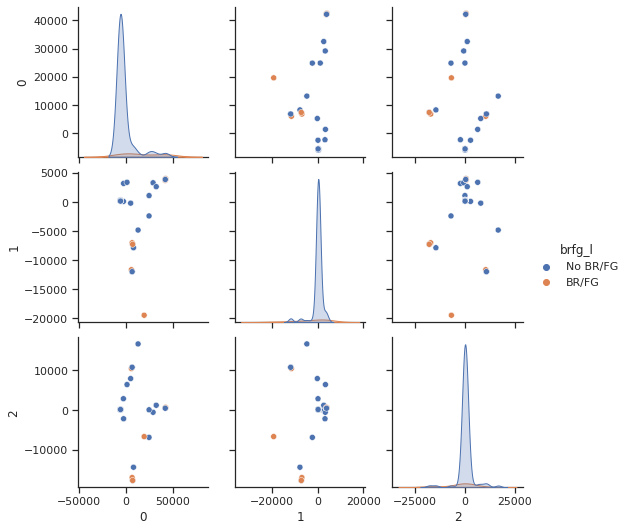

In [9]:
from sklearn.decomposition import PCA

df_pca = pd.DataFrame(PCA(n_components=3).fit_transform(df_all1k.iloc[:,1:]),
                                                        index =df_all1k.index)
df_pca["brfg_l"] = df_all1k.brfg_l
sns.pairplot(df_pca.sample(100), hue="brfg_l");

In [ ]:
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyClassifier

# X and Y
Y = df_all1k.brfg_l
X = df_all1k.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )


multiple_model = LazyClassifier(verbose =0, ignore_warnings = True,predictions=True)
models,predictions = multiple_model.fit(X_train,X_test,y_train,y_test)


 38%|███▊      | 11/29 [03:03<01:42,  5.72s/it]

In [ ]:
models

**Meteorological model independent variables X**

In [10]:
df_all1k.iloc[:,1:].columns

Index(['dir0', 'snow_prec0', 'snowlevel0', 'mod0', 'wind_gust0', 'mslp0',
       'temp0', 'rh0', 'visibility0', 'lhflx0', 'lwflx0', 'conv_prec0',
       'prec0', 'swflx0', 'shflx0', 'cape0', 'cin0', 'cfh0', 'cfl0', 'cfm0',
       'cft0', 'HGT5000', 'HGT8500', 'T5000', 'T8500', 'dir1', 'snow_prec1',
       'snowlevel1', 'mod1', 'wind_gust1', 'mslp1', 'temp1', 'rh1',
       'visibility1', 'lhflx1', 'lwflx1', 'conv_prec1', 'prec1', 'swflx1',
       'shflx1', 'cape1', 'cin1', 'cfh1', 'cfl1', 'cfm1', 'cft1', 'HGT5001',
       'HGT8501', 'T5001', 'T8501', 'dir2', 'snow_prec2', 'snowlevel2', 'mod2',
       'wind_gust2', 'mslp2', 'temp2', 'rh2', 'visibility2', 'lhflx2',
       'lwflx2', 'conv_prec2', 'prec2', 'swflx2', 'shflx2', 'cape2', 'cin2',
       'cfh2', 'cfl2', 'cfm2', 'cft2', 'HGT5002', 'HGT8502', 'T5002', 'T8502',
       'dir3', 'snow_prec3', 'snowlevel3', 'mod3', 'wind_gust3', 'mslp3',
       'temp3', 'rh3', 'visibility3', 'lhflx3', 'lwflx3', 'conv_prec3',
       'prec3', 'swflx3', '

**ML LGBMClassifier. Samples 10. Heidke Skill score. Significance level (alpha) = 0.01 for normality test of HSS samples**


Confusion matrix (Machine Learning)

col_0     BR/FG  No BR/FG   All
brfg_l                         
BR/FG       681       362  1043
No BR/FG    726      6565  7291
All        1407      6927  8334
Heidke Skill Score: 0.48

Quality report (Machine Learning)

              precision    recall  f1-score     support
BR/FG          0.484009  0.652924  0.555918  1043.00000
No BR/FG       0.947741  0.900425  0.923477  7291.00000
accuracy       0.869450  0.869450  0.869450     0.86945
macro avg      0.715875  0.776675  0.739698  8334.00000
weighted avg   0.889705  0.869450  0.877477  8334.00000

Confusion matrix (Machine Learning)

col_0     BR/FG  No BR/FG   All
brfg_l                         
BR/FG       633       366   999
No BR/FG    701      6634  7335
All        1334      7000  8334
Heidke Skill Score: 0.47

Quality report (Machine Learning)

              precision    recall  f1-score     support
BR/FG          0.474513  0.633634  0.542649   999.00000
No BR/FG       0.947714  0.904431 

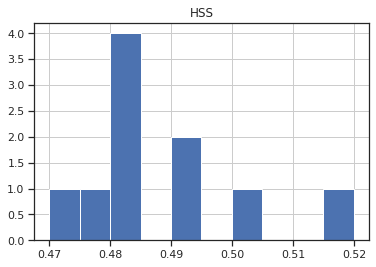

In [12]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all1k.brfg_l
X = df_all1k.iloc[:,1:]


# loop random
HSS = []
for t in range (0,10):

  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  print("\nConfusion matrix (Machine Learning)\n")

  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  print(cm)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  print("Heidke Skill Score:",round(HSS[t],2))

  #quality report
  print("\nQuality report (Machine Learning)\n")
  print(pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T)

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("\np value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")  

pd.DataFrame(HSS,columns=["HSS"]).hist();

**Add time features**

In [13]:
df_all1k["hour"] = df_all1k.index.hour
df_all1k["month"] = df_all1k.index.month
df_all1k["dayofyear"] = df_all1k.index.dayofyear
df_all1k["weekofyear"] = df_all1k.index.isocalendar().week.astype(int) 

In [14]:
df_all1k.iloc[:,1:].columns

Index(['dir0', 'snow_prec0', 'snowlevel0', 'mod0', 'wind_gust0', 'mslp0',
       'temp0', 'rh0', 'visibility0', 'lhflx0',
       ...
       'cfm3', 'cft3', 'HGT5003', 'HGT8503', 'T5003', 'T8503', 'hour', 'month',
       'dayofyear', 'weekofyear'],
      dtype='object', length=104)

In [ ]:
# X and Y
Y = df_all1k.brfg_l
X = df_all1k.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

multiple_model = LazyClassifier(verbose =0, ignore_warnings = True,predictions=True)
models,predictions = multiple_model.fit(X_train,X_test,y_train,y_test)
models

100%|██████████| 29/29 [00:58<00:00,  2.01s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelPropagation,0.88,0.81,None,0.88,7.42
LabelSpreading,0.88,0.81,None,0.88,11.21
ExtraTreesClassifier,0.90,0.79,None,0.90,1.45
LGBMClassifier,0.90,0.79,None,0.89,0.96
BaggingClassifier,0.88,0.78,None,0.88,4.67
RandomForestClassifier,0.90,0.78,None,0.89,6.96
KNeighborsClassifier,0.88,0.77,None,0.88,1.20
Perceptron,0.83,0.75,None,0.83,0.19
DecisionTreeClassifier,0.85,0.75,None,0.85,0.81



Confusion matrix (Machine Learning)

col_0     BR/FG  No BR/FG   All
brfg_l                         
BR/FG       718       325  1043
No BR/FG    646      6645  7291
All        1364      6970  8334
Heidke Skill Score: 0.53

Quality report (Machine Learning)

              precision    recall  f1-score      support
BR/FG          0.526393  0.688399  0.596593  1043.000000
No BR/FG       0.953372  0.911398  0.931912  7291.000000
accuracy       0.883489  0.883489  0.883489     0.883489
macro avg      0.739882  0.799898  0.764253  8334.000000
weighted avg   0.899935  0.883489  0.889947  8334.000000

Confusion matrix (Machine Learning)

col_0     BR/FG  No BR/FG   All
brfg_l                         
BR/FG       647       352   999
No BR/FG    580      6755  7335
All        1227      7107  8334
Heidke Skill Score: 0.52

Quality report (Machine Learning)

              precision    recall  f1-score      support
BR/FG          0.527302  0.647648  0.581312   999.000000
No BR/FG       0.950471  0

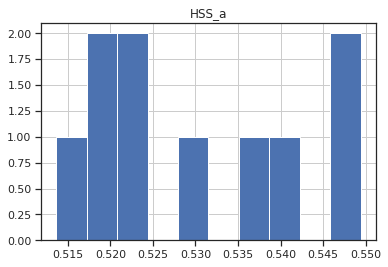

In [15]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all1k.brfg_l
X = df_all1k.iloc[:,1:]
#X = df_all1k[["rh0","visibility0","mod0","rh1","visibility1","mod1",'hour', 'month','dayofyear']]

# loop random
HSS_a = []
for t in range (0,10):

  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  #ml_model = ExtraTreeClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  print("\nConfusion matrix (Machine Learning)\n")

  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  print(cm)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_a.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  print("Heidke Skill Score:",round(HSS_a[t],2))

  #quality report
  print("\nQuality report (Machine Learning)\n")
  print(pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T)

print("\nHSS stadistics")
# if p-value is lower than 1%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_a,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_a)
print("\np value:",p)

#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null Hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")  

pd.DataFrame(HSS_a,columns=["HSS_a"]).hist();

In [16]:
feature_importances = ml_model.feature_importances_
total_sum = sum(feature_importances)
feature_importances_perc = [(importance/total_sum)*100 for importance in feature_importances]
# Print the feature importances as a percentage of total feature importance

for name, importance in zip(X.columns, feature_importances_perc):
    print(f"{name}: {importance:.1f}%")

dir0: 1.4%
snow_prec0: 0.0%
snowlevel0: 1.2%
mod0: 0.9%
wind_gust0: 1.4%
mslp0: 1.0%
temp0: 0.7%
rh0: 1.8%
visibility0: 1.1%
lhflx0: 1.1%
lwflx0: 0.8%
conv_prec0: 0.1%
prec0: 1.0%
swflx0: 0.8%
shflx0: 1.1%
cape0: 1.1%
cin0: 0.9%
cfh0: 1.6%
cfl0: 1.0%
cfm0: 0.9%
cft0: 0.5%
HGT5000: 1.2%
HGT8500: 1.0%
T5000: 0.8%
T8500: 1.3%
dir1: 1.3%
snow_prec1: 0.0%
snowlevel1: 1.0%
mod1: 0.9%
wind_gust1: 1.7%
mslp1: 0.9%
temp1: 0.9%
rh1: 1.2%
visibility1: 1.2%
lhflx1: 1.2%
lwflx1: 1.0%
conv_prec1: 0.2%
prec1: 1.3%
swflx1: 0.4%
shflx1: 1.2%
cape1: 1.0%
cin1: 0.8%
cfh1: 1.3%
cfl1: 0.7%
cfm1: 0.4%
cft1: 0.7%
HGT5001: 0.8%
HGT8501: 0.8%
T5001: 1.0%
T8501: 0.8%
dir2: 1.5%
snow_prec2: 0.0%
snowlevel2: 1.1%
mod2: 1.0%
wind_gust2: 1.5%
mslp2: 1.0%
temp2: 0.9%
rh2: 1.1%
visibility2: 1.1%
lhflx2: 1.0%
lwflx2: 1.0%
conv_prec2: 0.1%
prec2: 0.7%
swflx2: 0.3%
shflx2: 0.9%
cape2: 0.7%
cin2: 0.6%
cfh2: 0.6%
cfl2: 0.9%
cfm2: 0.4%
cft2: 0.6%
HGT5002: 0.8%
HGT8502: 1.0%
T5002: 0.9%
T8502: 1.5%
dir3: 1.5%
snow_prec3: 0.

**Test association between observed variable and machine learning forecast (Pearson’s chi square test). Significance level (alpha) = 0.01**

In [17]:
from scipy.stats import chi2_contingency

print("Last confusion matrix\n")
print(cm.iloc[0:2,0:2])

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

Last confusion matrix

col_0     BR/FG  No BR/FG
brfg_l                   
BR/FG       722       320
No BR/FG    598      6694

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2547.8564103750928
Reject H0,There is an association between machine learning forecast and observed values


**T test two related samples. This is a test for the null hypothesis that two related samples have identical HSS means. Alternative hypothesis the mean of the distribution underlying the sample without time variables is less than the mean of the distribution underlying the sample with time variables. Significance level (alpha) = 0.01**

In [18]:
from scipy import stats

alpha = 0.01
sta, p_value = stats.ttest_rel(HSS, HSS_a, alternative="less")

print("\nmeans without time variables:", np.round(HSS,2))
print("\nmeans with time variables:", np.round(HSS_a,2))

print("\nalpha: ",alpha)

print("\np_value point: ",p_value)
if p_value < alpha:    
    print("\nwe are rejecting null hypothesis  H0: HHS mean without time variables = HSS mean with time variables")
    print("\nwe are accepting alternative hypothesis: the HSS mean of the sample without time variables inputs is less than the HSS mean of the sample with time variables inputs")
else:
    print("\nwe are accepting null hypothesis:  H0: HSS mean without time variables = HSS mean with time variables ")


means without time variables: [0.48 0.47 0.52 0.48 0.48 0.49 0.49 0.48 0.5  0.48]

means with time variables: [0.53 0.52 0.55 0.51 0.52 0.52 0.54 0.52 0.54 0.55]

alpha:  0.01

p_value point:  7.015535953435741e-07

we are rejecting null hypothesis  H0: HHS mean without time variables = HSS mean with time variables

we are accepting alternative hypothesis: the HSS mean of the sample without time variables inputs is less than the HSS mean of the sample with time variables inputs


In [19]:
import pickle
from sklearn.pipeline import Pipeline

estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)
print(pipe)
al_file={"x_var":X.columns,"coor":coor,"pipe":pipe}
pickle.dump(al_file, open("brfg_LEST_d0.al", 'wb'))

Pipeline(steps=[('ml_model', LGBMClassifier(n_estimators=200))])


In [20]:
import sklearn
print(sklearn.__version__)

1.2.2


**Best algorithm too heavy to upload in github!!**

In [21]:
df_all1k.iloc[:,1:].columns

Index(['dir0', 'snow_prec0', 'snowlevel0', 'mod0', 'wind_gust0', 'mslp0',
       'temp0', 'rh0', 'visibility0', 'lhflx0',
       ...
       'cfm3', 'cft3', 'HGT5003', 'HGT8503', 'T5003', 'T8503', 'hour', 'month',
       'dayofyear', 'weekofyear'],
      dtype='object', length=104)

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all1k.brfg_l
X = df_all1k.iloc[:,1:]

# loop random
HSS_b = []
for t in range (0,10):
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.15, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  ml_model = ExtraTreesClassifier(n_estimators=300).fit(X_res,y_res)

  #Confussion matrix

  print("\nConfusion matrix (Machine Learning)\n")

  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  print(cm)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_b.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  print("Heidke Skill Score:",round(HSS_b[t],2))

  #quality report

  print("\nQuality report (Machine Learning)\n")
  print(pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T)

print("\nHSS stadistics")
pd.DataFrame(HSS_b,columns=["HSS"]).describe()


Confusion matrix (Machine Learning)

col_0     BR/FG  No BR/FG   All
brfg_l                         
BR/FG       554       223   777
No BR/FG    331      5143  5474
All         885      5366  6251
Heidke Skill Score: 0.62

Quality report (Machine Learning)

              precision    recall  f1-score      support
BR/FG          0.625989  0.712999  0.666667   777.000000
No BR/FG       0.958442  0.939532  0.948893  5474.000000
accuracy       0.911374  0.911374  0.911374     0.911374
macro avg      0.792215  0.826266  0.807780  6251.000000
weighted avg   0.917118  0.911374  0.913812  6251.000000

Confusion matrix (Machine Learning)

col_0     BR/FG  No BR/FG   All
brfg_l                         
BR/FG       538       231   769
No BR/FG    332      5150  5482
All         870      5381  6251
Heidke Skill Score: 0.6

Quality report (Machine Learning)

              precision    recall  f1-score      support
BR/FG          0.618391  0.699610  0.656498   769.000000
No BR/FG       0.957071  0.

,HSS
count,10.000000
mean,0.616247
std,0.011263
min,0.597900
25%,0.612821
50%,0.614452
75%,0.618560
max,0.635129


**T test two related samples. This is a test for the null hypothesis that two related samples have identical HSS means. Alternative hypothesis the mean of the distribution underlying the sample without time variables is less than the mean of the distribution underlying the sample with time variables. Significance level (alpha) = 0.01**

In [23]:
from scipy import stats

alpha = 0.01
sta, p_value = stats.ttest_rel(HSS_a, HSS_b, alternative="less")

print("\nHSS LGBMClassifier:", np.round(HSS_a,2))
print("\nHSS ExtraTreesClassifier:", np.round(HSS_b,2))

print("\nalpha: ",alpha)

print("\np_value point: ",p_value)
if p_value < alpha:    
    print("\nwe are rejecting null hypothesis  H0: HHS mean ExtraTreesClassifier = HSS mean with LGBMClassifier")
    print("\nwe are accepting alternative hypothesis: the HSS mean of the sample LGBMClassifier is less than the HSS mean of the sample with ExtraTreesClassifier")
else:
    print("\nwe are accepting null hypothesis:  H0: HSS mean LGBMClassifier = HSS mean with ExtraTreesClassifier")


HSS LGBMClassifier: [0.53 0.52 0.55 0.51 0.52 0.52 0.54 0.52 0.54 0.55]

HSS ExtraTreesClassifier: [0.62 0.6  0.6  0.61 0.61 0.62 0.61 0.64 0.62 0.63]

alpha:  0.01

p_value point:  3.547303500521213e-08

we are rejecting null hypothesis  H0: HHS mean ExtraTreesClassifier = HSS mean with LGBMClassifier

we are accepting alternative hypothesis: the HSS mean of the sample LGBMClassifier is less than the HSS mean of the sample with ExtraTreesClassifier


**PCA components**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all1k.brfg_l
X = df_all1k.iloc[:,1:]

# loop random
HSS_pca = []
for t in range (0,10):
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.15, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #scaler
  sc = StandardScaler().fit(X_res)
  X_sc = sc.transform(X_res)

  #PCA
  n_components = len(X.columns)
  pca = PCA(n_components).fit(X_sc)
  X_pca = pca.transform(X_sc)

  #machine learning model
  #ml_model = ExtraTreesClassifier(n_estimators=150).fit(X_pca,y_res)
  ml_model = MLPClassifier(hidden_layer_sizes=(100,50,10)).fit(X_pca,y_res)
  
  #Confusion matrix
  print("\nConfusion matrix (Machine Learning)\n")

  y_pca = pca.transform(sc.transform(X_test))
  cm = pd.crosstab(y_test, ml_model.predict(y_pca),margins=True,)
  print(cm)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_pca.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  print("Heidke Skill Score:",round(HSS_pca[t],2))

  #quality report

  print("\nQuality report (Machine Learning)\n")
  print(pd.DataFrame(classification_report(y_test, ml_model.predict(y_pca),output_dict=True)).T)

print("\nHSS stadistics")
pd.DataFrame(HSS_pca,columns=["HSS_pca"]).describe()


Confusion matrix (Machine Learning)

col_0     BR/FG  No BR/FG   All
brfg_l                         
BR/FG       287       150   437
No BR/FG    179      1855  2034
All         466      2005  2471
Heidke Skill Score: 0.55

Quality report (Machine Learning)

              precision    recall  f1-score      support
BR/FG          0.615880  0.656751  0.635659   437.000000
No BR/FG       0.925187  0.911996  0.918544  2034.000000
accuracy       0.866856  0.866856  0.866856     0.866856
macro avg      0.770533  0.784373  0.777102  2471.000000
weighted avg   0.870486  0.866856  0.868516  2471.000000

Confusion matrix (Machine Learning)

col_0     BR/FG  No BR/FG   All
brfg_l                         
BR/FG       288       173   461
No BR/FG    208      1802  2010
All         496      1975  2471
Heidke Skill Score: 0.51

Quality report (Machine Learning)

              precision    recall  f1-score      support
BR/FG          0.580645  0.624729  0.601881   461.000000
No BR/FG       0.912405  0

,HSS_pca
count,10.000000
mean,0.563400
std,0.029173
min,0.506431
25%,0.553074
50%,0.562969
75%,0.584901
max,0.604646
